COVID-19 Data Capstone: In this capstone the spread of COVID-19 during the Coronavirus pandemic will be studied in the form of total cases per million by country, total deaths per million, and deathrate by country by a certain date (November, 27,2020). The goal is to find which factors of countries lead to a greater spread and deathrate in COVID in the country. The data used is from Our World in Data combined with mobility data from Google's Community COVID-19 Mobility Reports. 

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

#Reading in Our World in Data and Global Mobility Data
owid = pd.read_csv('owid-covid-data.csv')
mobility = pd.read_csv('global_mobility_report.csv')

#Getting the first date of each country
firstdatedf = owid[(owid.total_cases > 0)].groupby(['location']).first().reset_index()
firstdate = firstdatedf.loc[:,['location','date']]
stringency_index = firstdatedf.stringency_index

#Filter for November,27,2020
owid = owid.loc[owid.date == '11/27/20']
owid = owid.drop(columns = ['iso_code','new_cases','new_cases_smoothed','new_deaths','new_deaths_smoothed','new_cases_per_million',
                     'new_cases_smoothed_per_million','new_deaths_per_million','new_deaths_smoothed_per_million',
                     'weekly_icu_admissions','weekly_icu_admissions_per_million','weekly_hosp_admissions',
                     'weekly_hosp_admissions_per_million','new_tests','new_tests_per_thousand','new_tests_smoothed',
                     'new_tests_smoothed_per_thousand','reproduction_rate','icu_patients','icu_patients_per_million','hosp_patients',
                    'hosp_patients_per_million','total_tests','total_tests_per_thousand','tests_per_case','tests_units'],axis=1)
owid = owid.rename({'location':'country'},axis=1)
owid = owid[ ['country'] + [ col for col in owid.columns if col != 'country' ] ]

#Making owid DataFrame exclusively for 11/27/20
owid = pd.merge(owid,firstdate,left_on='country',right_on='location',how='left')
owid = owid.rename({'date_y':'first_case'},axis=1)
owid = owid.rename({'date_x':'date'},axis=1)
owid = owid.drop(columns = ['location'])
owid['date'] = owid['date'].astype('datetime64[ns]')
owid['first_case'] = owid['first_case'].astype('datetime64[ns]')
owid['days_since_firstcase'] = (owid.date - owid.first_case)
owid['days_since_firstcase'] = owid['days_since_firstcase'].dt.total_seconds() / (24 * 60 * 60)
owid['avg_daily_new_cases_per_million'] = (owid.total_cases_per_million / owid.days_since_firstcase)
owid['avg_daily_new_deaths_per_million'] = (owid.total_deaths_per_million / owid.days_since_firstcase)
owid.head()

/Users/faizankhan/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,country,continent,date,total_cases,total_deaths,total_cases_per_million,total_deaths_per_million,positive_rate,stringency_index,population,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,first_case,days_since_firstcase,avg_daily_new_cases_per_million,avg_daily_new_deaths_per_million
0,Aruba,North America,2020-11-27,4791.0,45.0,44873.836,421.482,NaN,NaN,106766.0,...,NaN,NaN,NaN,NaN,76.29,NaN,2020-03-13,259.0,173.258054,1.627344
1,Afghanistan,Asia,2020-11-27,45402.0,1737.0,1166.297,44.620,NaN,NaN,38928341.0,...,NaN,NaN,37.746,0.50,64.83,0.498,2020-02-25,276.0,4.225714,0.161667
2,Angola,Africa,2020-11-27,14821.0,340.0,450.949,10.345,NaN,NaN,32866268.0,...,NaN,NaN,26.664,NaN,61.15,0.581,2020-03-22,250.0,1.803796,0.041380
3,Anguilla,North America,2020-11-27,4.0,NaN,266.631,NaN,NaN,NaN,15002.0,...,NaN,NaN,NaN,NaN,81.88,NaN,2020-03-27,245.0,1.088290,NaN
4,Albania,Europe,2020-11-27,35600.0,753.0,12370.561,261.658,NaN,NaN,2877800.0,...,7.1,51.2,NaN,2.89,78.57,0.785,2020-03-09,263.0,47.036354,0.994897


In [38]:
#Merging OWID Data and Google Mobility Report Data

retail_rec_avg_change = mobility.loc[:,'retail_and_recreation_percent_change_from_baseline'].groupby(mobility.country_region).mean()
grocery_pharmacy_avg_change = mobility.loc[:,'grocery_and_pharmacy_percent_change_from_baseline'].groupby(mobility.country_region).mean()
parks_avg_change = mobility.loc[:,'parks_percent_change_from_baseline'].groupby(mobility.country_region).mean()
transit_station_avg_change = mobility.loc[:,'transit_stations_percent_change_from_baseline'].groupby(mobility.country_region).mean()
workplace_avg_change = mobility.loc[:,'workplaces_percent_change_from_baseline'].groupby(mobility.country_region).mean()
residential_avg_change = mobility.loc[:,'residential_percent_change_from_baseline'].groupby(mobility.country_region).mean()

retail_rec_peak_change = mobility.loc[:,'retail_and_recreation_percent_change_from_baseline'].groupby(mobility.country_region).min()
grocery_pharmacy_peak_change = mobility.loc[:,'grocery_and_pharmacy_percent_change_from_baseline'].groupby(mobility.country_region).min()
parks_peak_change = mobility.loc[:,'parks_percent_change_from_baseline'].groupby(mobility.country_region).min()
transit_station_peak_change = mobility.loc[:,'transit_stations_percent_change_from_baseline'].groupby(mobility.country_region).min()
workplace_peak_change = mobility.loc[:,'workplaces_percent_change_from_baseline'].groupby(mobility.country_region).min()
residential_peak_change = mobility.loc[:,'residential_percent_change_from_baseline'].groupby(mobility.country_region).max()

owid = pd.merge(owid,retail_rec_avg_change,left_on='country',right_on='country_region',how='left')
owid = pd.merge(owid,retail_rec_peak_change,left_on='country',right_on='country_region',how='left')
owid = pd.merge(owid,grocery_pharmacy_avg_change,left_on='country',right_on='country_region',how='left')
owid = pd.merge(owid,grocery_pharmacy_peak_change,left_on='country',right_on='country_region',how='left')
owid = pd.merge(owid,parks_avg_change,left_on='country',right_on='country_region',how='left')
owid = pd.merge(owid,parks_peak_change,left_on='country',right_on='country_region',how='left')
owid = pd.merge(owid,transit_station_avg_change,left_on='country',right_on='country_region',how='left')
owid = pd.merge(owid,transit_station_peak_change,left_on='country',right_on='country_region',how='left')
owid = pd.merge(owid,workplace_avg_change,left_on='country',right_on='country_region',how='left')
owid = pd.merge(owid,workplace_peak_change,left_on='country',right_on='country_region',how='left')
owid = pd.merge(owid,residential_avg_change,left_on='country',right_on='country_region',how='left')
owid = pd.merge(owid,residential_peak_change,left_on='country',right_on='country_region',how='left')

owid = owid.loc[:,~owid.columns.duplicated()]

owid = owid.rename({'retail_and_recreation_percent_change_from_baseline_x':'retail_rec_avg_change',
                    'retail_and_recreation_percent_change_from_baseline_y':'retail_rec_peak_change',
                   'grocery_and_pharmacy_percent_change_from_baseline_x': 'grocery_pharmacy_avg_change',
                   'grocery_and_pharmacy_percent_change_from_baseline_y': 'grocery_pharmacy_peak_change',
                    'parks_percent_change_from_baseline_x':'parks_avg_change' ,
                   'parks_percent_change_from_baseline_y':'parks_peak_change',
                   'transit_stations_percent_change_from_baseline_x':'transit_station_avg_change',
                   'transit_stations_percent_change_from_baseline_y':'transit_station_peak_change',
                    'workplaces_percent_change_from_baseline_x':'workplace_avg_change',
                   'workplaces_percent_change_from_baseline_y':'workplace_peak_change',
                   'residential_percent_change_from_baseline_x':'residential_avg_change',
                   'residential_percent_change_from_baseline_y':'residential_peak_change',},axis=1)
owid = owid.loc[:,~owid.columns.duplicated()]

owid['stringency_index'] = stringency_index
owid.columns



Index(['country', 'continent', 'date', 'total_cases', 'total_deaths',
       'total_cases_per_million', 'total_deaths_per_million', 'positive_rate',
       'stringency_index', 'population', 'population_density', 'median_age',
       'aged_65_older', 'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
       'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers',
       'male_smokers', 'handwashing_facilities', 'hospital_beds_per_thousand',
       'life_expectancy', 'human_development_index', 'first_case',
       'days_since_firstcase', 'avg_daily_new_cases_per_million',
       'avg_daily_new_deaths_per_million', 'retail_rec_avg_change',
       'retail_rec_peak_change', 'grocery_pharmacy_avg_change',
       'grocery_pharmacy_peak_change', 'parks_avg_change', 'parks_peak_change',
       'transit_station_avg_change', 'transit_station_peak_change',
       'workplace_avg_change', 'workplace_peak_change',
       'residential_avg_change', 'residential_peak_change'],
      dtype='o

In [39]:
#Including testing data and deathrate for additional information

extra = pd.read_csv('testInfo.csv')
extrainfo = extra[['country','testspermillion','deathrate']].copy()
extrainfo.head()
owid = pd.merge(owid,extrainfo,on='country',how='left')
owid.columns

Index(['country', 'continent', 'date', 'total_cases', 'total_deaths',
       'total_cases_per_million', 'total_deaths_per_million', 'positive_rate',
       'stringency_index', 'population', 'population_density', 'median_age',
       'aged_65_older', 'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
       'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers',
       'male_smokers', 'handwashing_facilities', 'hospital_beds_per_thousand',
       'life_expectancy', 'human_development_index', 'first_case',
       'days_since_firstcase', 'avg_daily_new_cases_per_million',
       'avg_daily_new_deaths_per_million', 'retail_rec_avg_change',
       'retail_rec_peak_change', 'grocery_pharmacy_avg_change',
       'grocery_pharmacy_peak_change', 'parks_avg_change', 'parks_peak_change',
       'transit_station_avg_change', 'transit_station_peak_change',
       'workplace_avg_change', 'workplace_peak_change',
       'residential_avg_change', 'residential_peak_change', 'testspermillio

In [40]:
#Ordering DataFrame based on preferred order
owid = owid[['country', 'continent','first_case','total_cases_per_million', 'total_deaths_per_million', 'deathrate','testspermillion',
       'population', 'population_density', 'median_age',
        'aged_70_older', 'gdp_per_capita', 'extreme_poverty','stringency_index', 
       'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers',
       'male_smokers', 'handwashing_facilities', 'hospital_beds_per_thousand',
       'life_expectancy', 'human_development_index',
       'days_since_firstcase', 'retail_rec_avg_change',
       'retail_rec_peak_change', 'grocery_pharmacy_avg_change',
       'grocery_pharmacy_peak_change', 'parks_avg_change', 'parks_peak_change',
       'transit_station_avg_change', 'transit_station_peak_change',
       'workplace_avg_change', 'workplace_peak_change',
       'residential_avg_change', 'residential_peak_change']]

In [41]:
#Finding Null Values
owid.set_index('country',inplace= True)
nullvalues = owid.isnull().sum(axis=1)
null = nullvalues[nullvalues > 16]
print(null)

country
Anguilla                            26
Andorra                             19
Bonaire Sint Eustatius and Saba     26
Bermuda                             21
Central African Republic            17
Cote d'Ivoire                       17
Democratic Republic of Congo        17
Curacao                             22
Cayman Islands                      21
Dominica                            20
Eritrea                             17
Western Sahara                      23
Falkland Islands                    26
Faeroe Islands                      26
Guernsey                            28
Gibraltar                           24
Grenada                             18
Greenland                           24
Guam                                21
Isle of Man                         23
Jersey                              27
Saint Kitts and Nevis               21
Monaco                              21
Marshall Islands                    21
Macedonia                           17
Northern Mariana 

In [42]:
owid = owid[owid.isnull().sum(axis=1) < 17] #dropping rows with excessive missing countries
owid.head(50)
owid.index

Index(['Aruba', 'Afghanistan', 'Angola', 'Albania', 'United Arab Emirates',
       'Argentina', 'Armenia', 'Antigua and Barbuda', 'Australia', 'Austria',
       ...
       'Uruguay', 'United States', 'Uzbekistan', 'Venezuela', 'Vietnam',
       'Vanuatu', 'Yemen', 'South Africa', 'Zambia', 'Zimbabwe'],
      dtype='object', name='country', length=169)

In [43]:
#Too many null in handwashing column
owid = owid.drop(columns = 'handwashing_facilities')

In [44]:
print(owid[owid['human_development_index'].isnull()])

                 continent first_case  total_cases_per_million  \
country                                                          
Aruba        North America 2020-03-13                44873.836   
Puerto Rico  North America 2020-03-28                30502.580   
Taiwan                Asia 2020-01-21                   26.830   

             total_deaths_per_million  deathrate  testspermillion  population  \
country                                                                         
Aruba                         421.482   0.842012         371453.0    106766.0   
Puerto Rico                   373.666        NaN              NaN   2860840.0   
Taiwan                          0.294   1.261261           4278.0  23816775.0   

             population_density  median_age  aged_70_older  ...  \
country                                                     ...   
Aruba                   584.800        41.2          7.452  ...   
Puerto Rico             376.232        38.2          9.829  ..

In [45]:
owid.isnull().sum()

continent                        0
first_case                       0
total_cases_per_million          0
total_deaths_per_million         8
deathrate                       17
testspermillion                 22
population                       0
population_density               1
median_age                       1
aged_70_older                    2
gdp_per_capita                   3
extreme_poverty                 53
stringency_index                30
cardiovasc_death_rate            2
diabetes_prevalence              1
female_smokers                  33
male_smokers                    35
hospital_beds_per_thousand      18
life_expectancy                  0
human_development_index          3
days_since_firstcase             0
retail_rec_avg_change           44
retail_rec_peak_change          44
grocery_pharmacy_avg_change     44
grocery_pharmacy_peak_change    44
parks_avg_change                45
parks_peak_change               45
transit_station_avg_change      45
transit_station_peak

In [46]:
#Fill null deaths_per_million
owid.at['Bhutan','total_deaths_per_million'] = 0
owid.at['Cambodia','total_deaths_per_million'] = 0
owid.at['Laos','total_deaths_per_million'] = 0
owid.at['Mongolia','total_deaths_per_million'] = 0
owid.at['Solomon Islands','total_deaths_per_million'] = 0
owid.at['Seychelles','total_deaths_per_million'] = 0
owid.at['Timor','total_deaths_per_million'] = 0
owid.at['Vanuatu','total_deaths_per_million'] = 0.000001

#Fill null deathrate manually
for x in owid[owid['deathrate'].isnull()].index:
    owid.at[x,'deathrate'] = owid['total_deaths_per_million'][x] / owid['total_cases_per_million'][x]
    
#Fill rest with mean
owid.at['United Kingdom','testspermillion'] = 598499.625
owid.at['United States','testspermillion'] = 819159.664
owid.at['United Arab Emirates','testspermillion'] = 4082489
owid.at['South Korea','testspermillion'] = 56662.1543
owid.at['Taiwan','population_density'] = 673
owid.at['Liechtenstein','median_age'] = 41.42
owid.at['Cuba','gdp_per_capita'] = 8821.82
owid.at['Liechtenstein','gdp_per_capita'] = 181402.83
owid.at['Taiwan','gdp_per_capita'] = 25873.37
owid.at['Aruba','human_development_index'] = 0.908
owid.at['Puerto Rico','human_development_index']= 0.845
owid.at['Taiwan','human_development_index'] = 0.911
owid.at['Puerto Rico','life_expectancy']= 79.78

owid = owid.fillna(owid.mean())

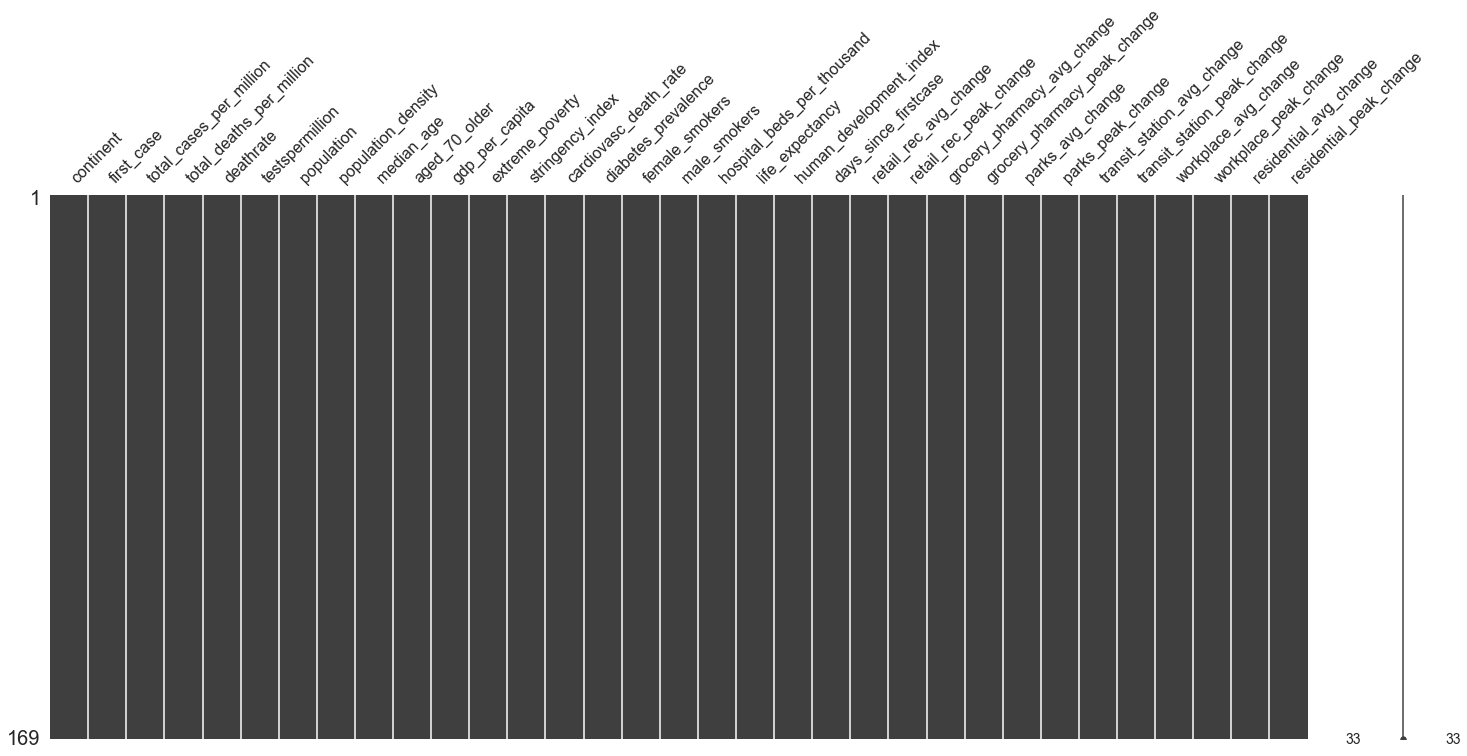

In [47]:
#Visualization of null data to fill
#After filling, there are no null values in DataFrame

import missingno as msno
%matplotlib inline
msno.matrix(owid)

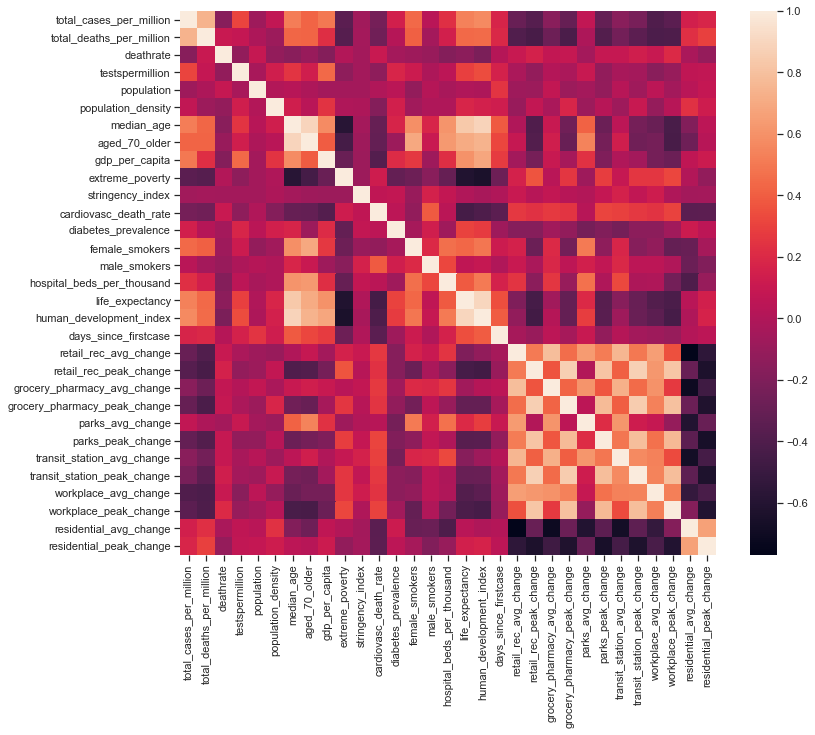

In [48]:
import seaborn as sns
plt.subplots(figsize=(12,10))
sns.heatmap(owid.corr())

In [50]:
#Only counting numeric values for pairplot on following line
owid.reset_index(inplace=True)
numeric = owid.drop(['country','continent','first_case'],axis=1)
numeric.head()

,total_cases_per_million,total_deaths_per_million,deathrate,testspermillion,population,population_density,median_age,aged_70_older,gdp_per_capita,extreme_poverty,...,grocery_pharmacy_avg_change,grocery_pharmacy_peak_change,parks_avg_change,parks_peak_change,transit_station_avg_change,transit_station_peak_change,workplace_avg_change,workplace_peak_change,residential_avg_change,residential_peak_change
0,44873.836,421.482,0.842012,371453.0,106766.0,584.800,41.2,7.452,35973.781,13.818966,...,-10.984127,-96.000,-11.948413,-88.000000,-46.023810,-92.00000,-28.258303,-91.000,12.501961,35.000000
1,1166.297,44.620,3.707906,3121.0,38928341.0,54.422,18.6,1.337,1803.987,13.818966,...,13.463768,-49.000,-3.363636,-52.000000,-11.403471,-53.00000,-13.689655,-72.000,6.202586,24.000000
2,450.949,10.345,2.628413,2567.0,32866268.0,23.890,16.8,1.362,5819.495,13.818966,...,-9.285000,-50.000,-11.775794,-72.000000,-36.749057,-76.00000,-11.706605,-77.000,13.202166,38.000000
3,12370.561,261.658,2.438323,41999.0,2877800.0,104.871,38.0,8.643,11803.431,1.100000,...,-8.008495,-74.288,-4.931956,-76.862903,-28.594530,-83.83871,-20.268558,-82.408,9.272144,36.756098
4,16578.399,57.025,0.003440,4082489.0,9890400.0,112.442,34.0,0.526,67293.483,13.818966,...,-8.975046,-63.000,-38.216202,-92.000000,-42.278103,-86.00000,-20.525594,-79.000,13.031874,41.000000


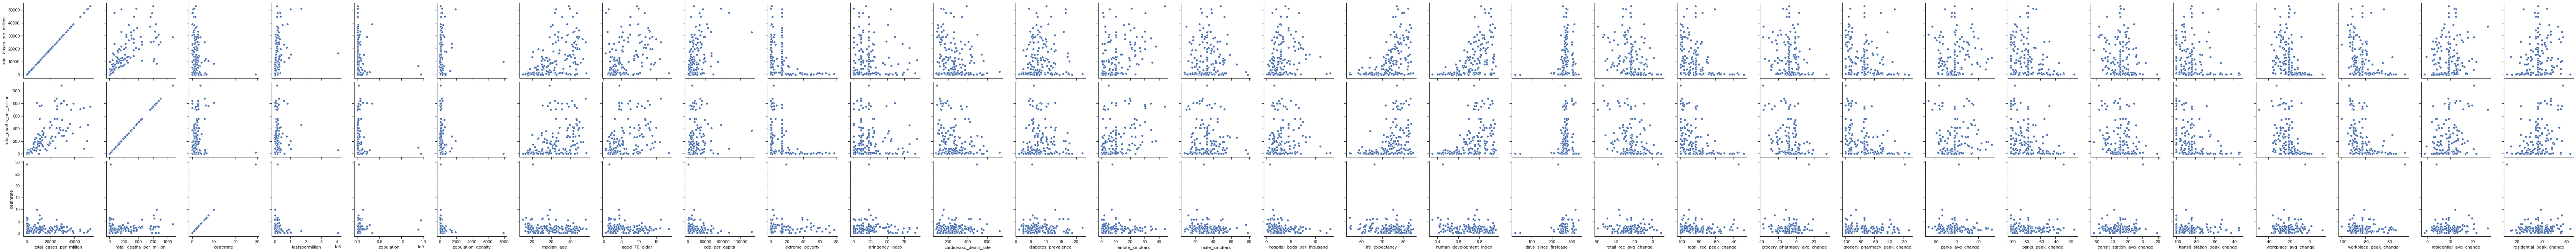

In [51]:
#Pairplot of correlations between each target variable and predictive
#Enlarged views of scatter plots with scroll bar available via download but does not display on GitHub

%matplotlib inline

from IPython.display import display, HTML
CSS = """div.output_area img {max-width:None !important;max-height: None !important";}"""
display(HTML('<style>{}</style>'.format(CSS)))

sns.set(style="ticks", color_codes=True)
g = sns.pairplot(data=numeric,y_vars=['total_cases_per_million','total_deaths_per_million','deathrate'],
                                   x_vars=numeric.columns, height = 3)
plt.show()

<ipython-input-53-e4f1548183bf>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(i)
<ipython-input-53-e4f1548183bf>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(i)
<ipython-input-53-e4f1548183bf>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(i)
<ipython-input-53-e4f1548183bf>:4: Runti

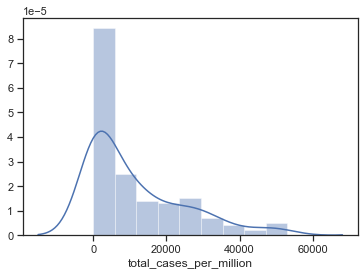

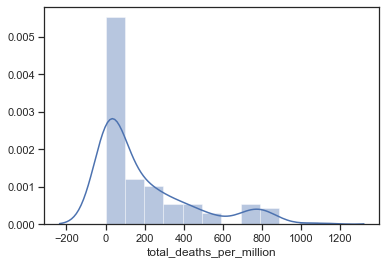

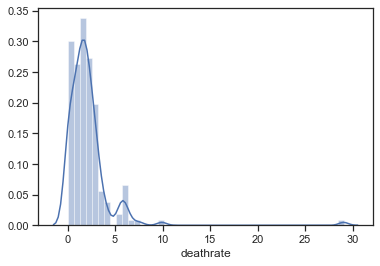

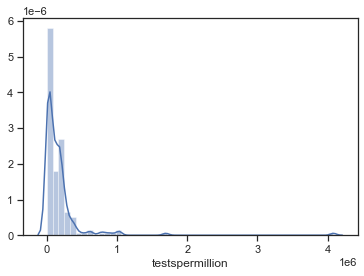

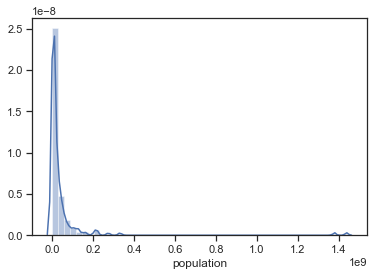

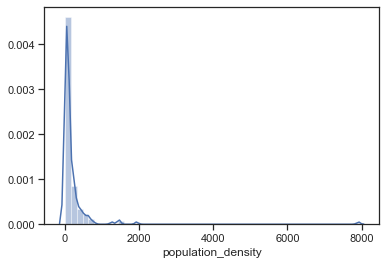

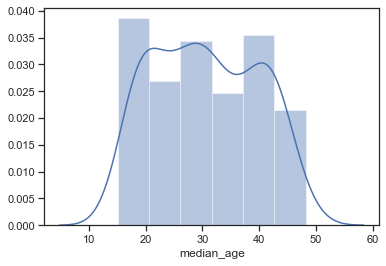

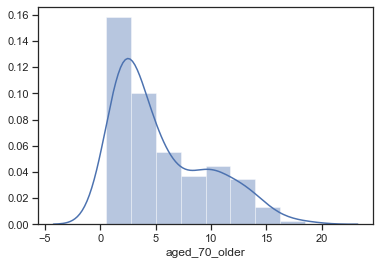

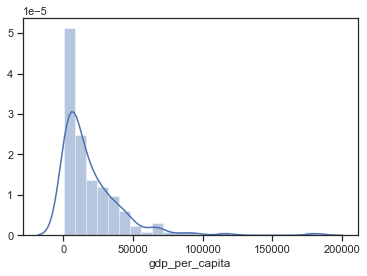

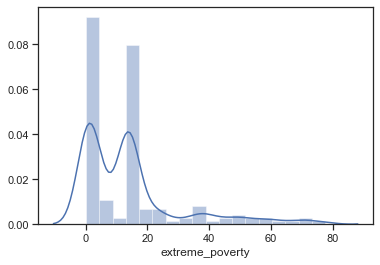

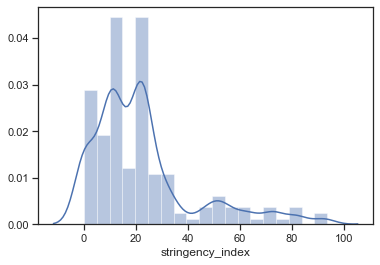

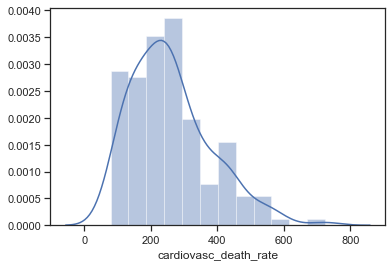

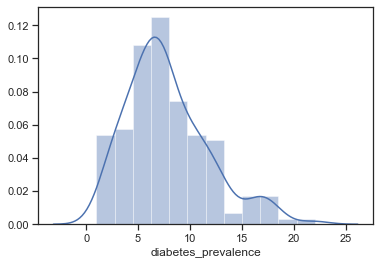

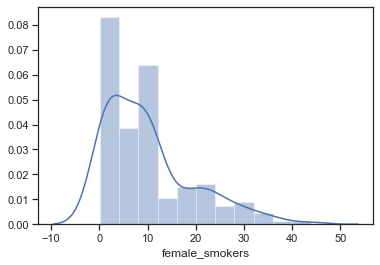

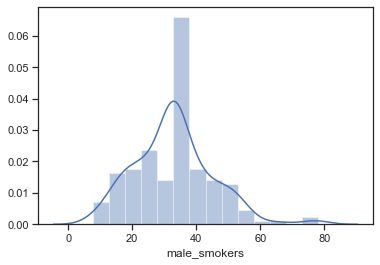

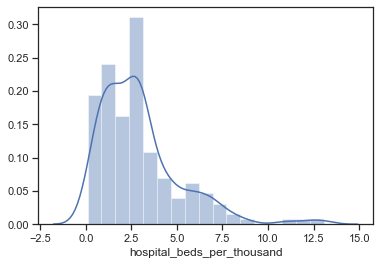

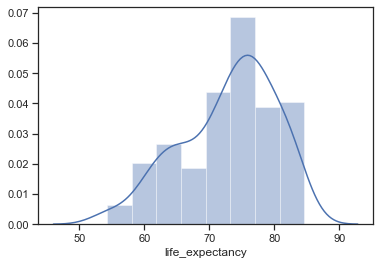

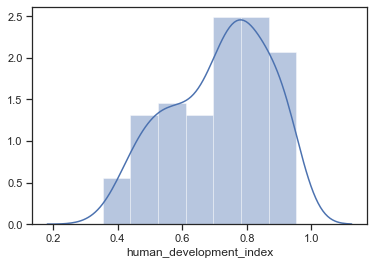

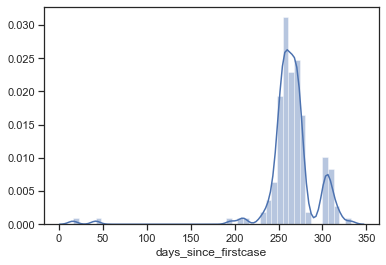

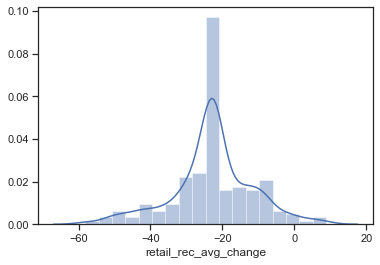

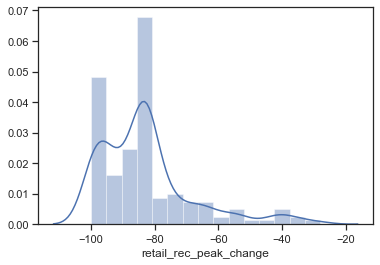

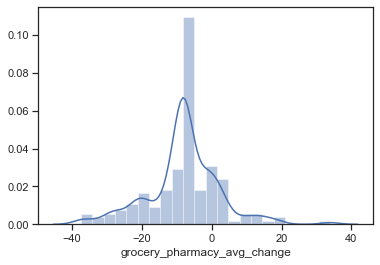

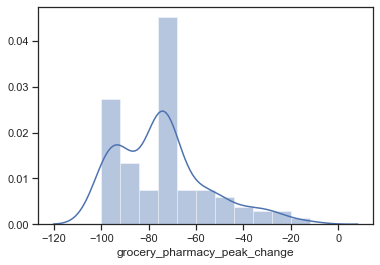

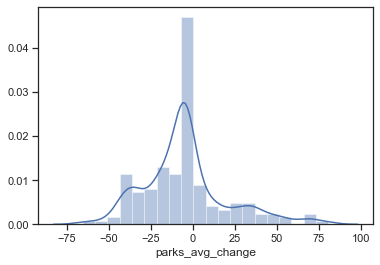

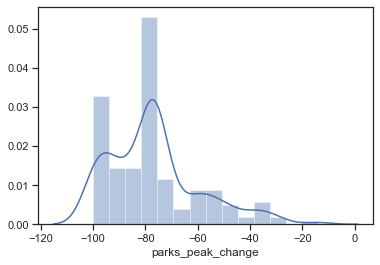

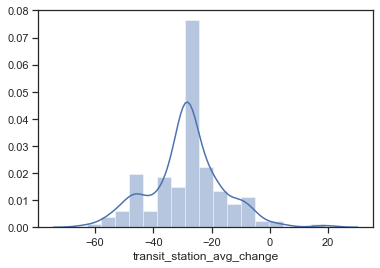

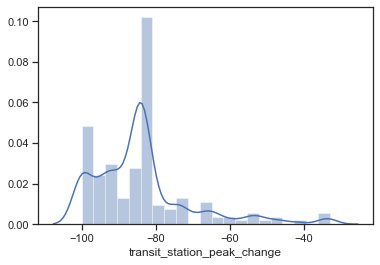

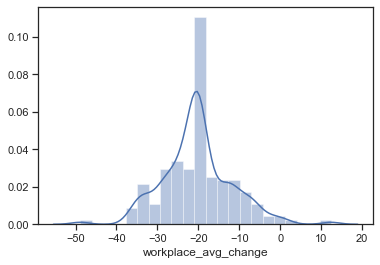

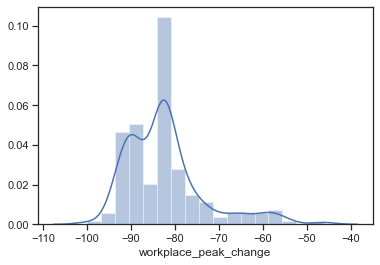

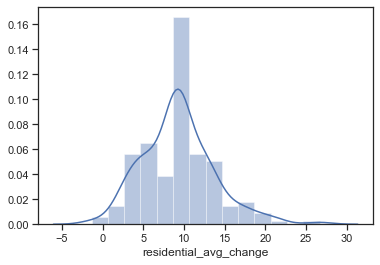

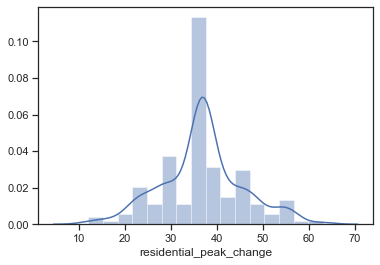

In [53]:
#Distributions of Columns to give understanding of Data

for i, col in enumerate(numeric.columns[0:]):
    plt.figure(i)
    sns.distplot(owid[col])

In [54]:
#Correlations
owid[owid.columns[1:]].corr()

,total_cases_per_million,total_deaths_per_million,deathrate,testspermillion,population,population_density,median_age,aged_70_older,gdp_per_capita,extreme_poverty,...,grocery_pharmacy_avg_change,grocery_pharmacy_peak_change,parks_avg_change,parks_peak_change,transit_station_avg_change,transit_station_peak_change,workplace_avg_change,workplace_peak_change,residential_avg_change,residential_peak_change
total_cases_per_million,1.000000,0.738042,-0.160957,0.313287,-0.075901,0.069165,0.521880,0.424522,0.496836,-0.350046,...,-0.158387,-0.303701,0.071785,-0.310730,-0.155378,-0.225715,-0.400775,-0.347812,0.148727,0.182660
total_deaths_per_million,0.738042,1.000000,0.105397,0.087281,-0.014109,-0.081263,0.428511,0.421592,0.225641,-0.374548,...,-0.275535,-0.421239,-0.014447,-0.386422,-0.249192,-0.344757,-0.414022,-0.405031,0.231294,0.296856
deathrate,-0.160957,0.105397,1.000000,-0.125437,0.090159,-0.115084,-0.155082,-0.095289,-0.175514,0.007458,...,0.079994,0.092624,-0.046660,0.092267,0.092694,0.142788,0.097446,0.201880,-0.029149,-0.106871
testspermillion,0.313287,0.087281,-0.125437,1.000000,-0.032710,0.142562,0.253680,0.139107,0.444502,-0.139244,...,0.016622,-0.015698,0.095902,-0.122480,-0.030932,-0.047451,-0.153850,-0.102967,0.064536,0.069269
population,-0.075901,-0.014109,0.090159,-0.032710,1.000000,0.005311,0.031978,-0.015407,-0.053135,-0.051032,...,0.077384,-0.080656,-0.045132,-0.117977,0.030664,-0.065985,0.051840,-0.055989,0.034474,0.085296
population_density,0.069165,-0.081263,-0.115084,0.142562,0.005311,1.000000,0.142628,0.037962,0.241002,-0.003686,...,-0.022975,0.179496,-0.081834,0.030459,-0.070826,0.097202,-0.109521,0.029546,0.238456,0.125763
median_age,0.521880,0.428511,-0.155082,0.253680,0.031978,0.142628,1.000000,0.890571,0.571924,-0.577219,...,0.098793,-0.259417,0.414760,-0.278388,0.051573,-0.241546,-0.290488,-0.423989,-0.188185,0.051314
aged_70_older,0.424522,0.421592,-0.095289,0.139107,-0.015407,0.037962,0.890571,1.000000,0.393801,-0.444459,...,0.139508,-0.295214,0.543686,-0.242638,0.138336,-0.262512,-0.237516,-0.431905,-0.266739,0.031344
gdp_per_capita,0.496836,0.225641,-0.175514,0.444502,-0.053135,0.241002,0.571924,0.393801,1.000000,-0.288516,...,0.099910,-0.042868,0.233246,-0.196141,0.003696,-0.055680,-0.237946,-0.278828,0.060500,0.119103
extreme_poverty,-0.350046,-0.374548,0.007458,-0.139244,-0.051032,-0.003686,-0.577219,-0.444459,-0.288516,1.000000,...,0.035063,0.259592,-0.071654,0.285258,0.093690,0.255666,0.256557,0.316407,0.005529,-0.121163


Observations regarding correlations from pairplot and correlation statistics:

Total cases per million strongly positively correlated with median age, gdp_per_capita, female smokers, human development index, and life expectancy, and strongly negatively correlated with extreme poverty and every type of mobility change especially workplace change and retail/recreation change.

Total deaths per million strongly positively correlated with median age, female smokers, human development index, and life expectancy, and strongly negatively correlated with extreme poverty and every type of mobility change especially workplace change and retail/recreation change.

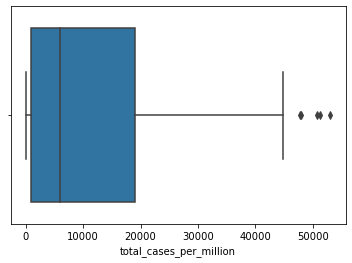

In [14]:
sns.boxplot(x=owid["total_cases_per_million"])

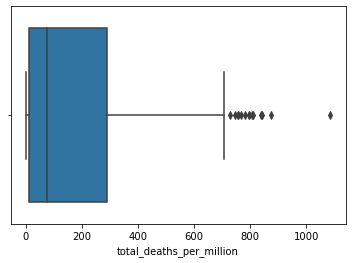

In [15]:
sns.boxplot(x=owid["total_deaths_per_million"])

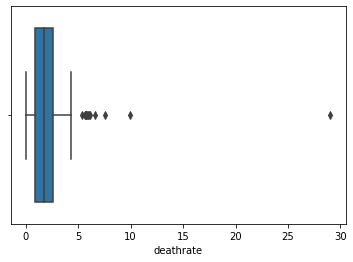

In [16]:
sns.boxplot(x=owid['deathrate'])

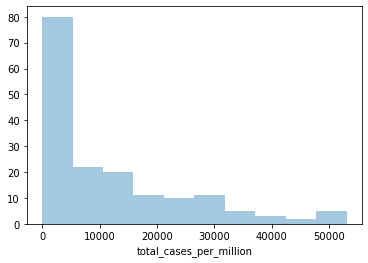

In [631]:
sns.distplot(owid['total_cases_per_million'],kde=False,bins=10)

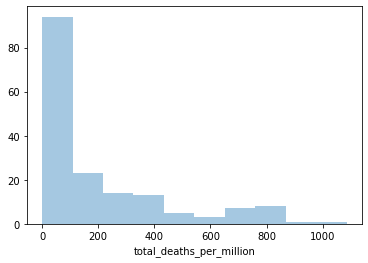

In [632]:
sns.distplot(owid['total_deaths_per_million'],kde=False,bins=10)

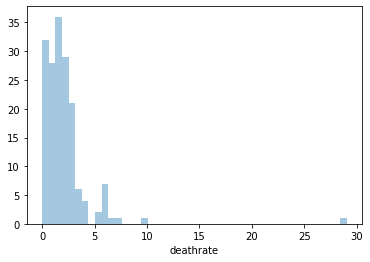

In [633]:
sns.distplot(owid['deathrate'],kde=False)

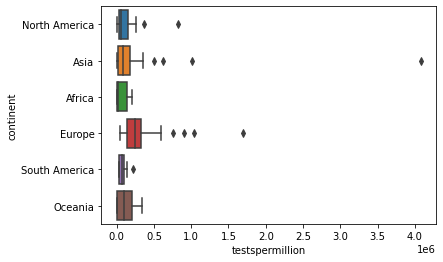

In [637]:
sns.boxplot(x="testspermillion",y="continent",data=owid)

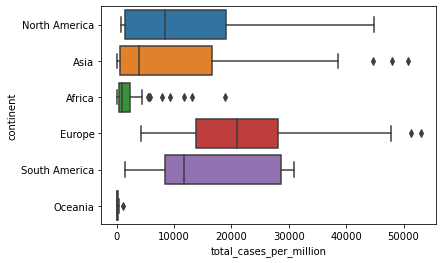

In [20]:
sns.boxplot(x="total_cases_per_million",y="continent",data=owid)

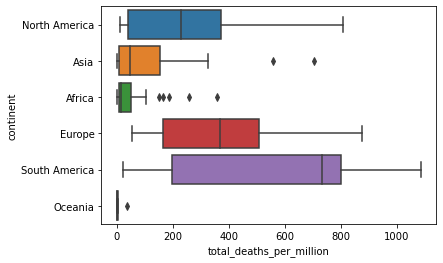

In [21]:
sns.boxplot(x="total_deaths_per_million",y="continent",data=owid)

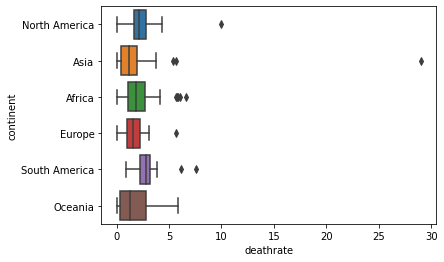

In [22]:
sns.boxplot(x="deathrate",y="continent",data=owid)

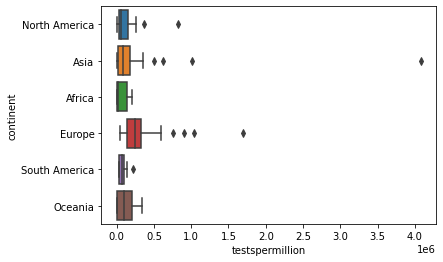

In [23]:
sns.boxplot(x="testspermillion",y="continent",data=owid)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11ca2a820>,
      dtype=object)

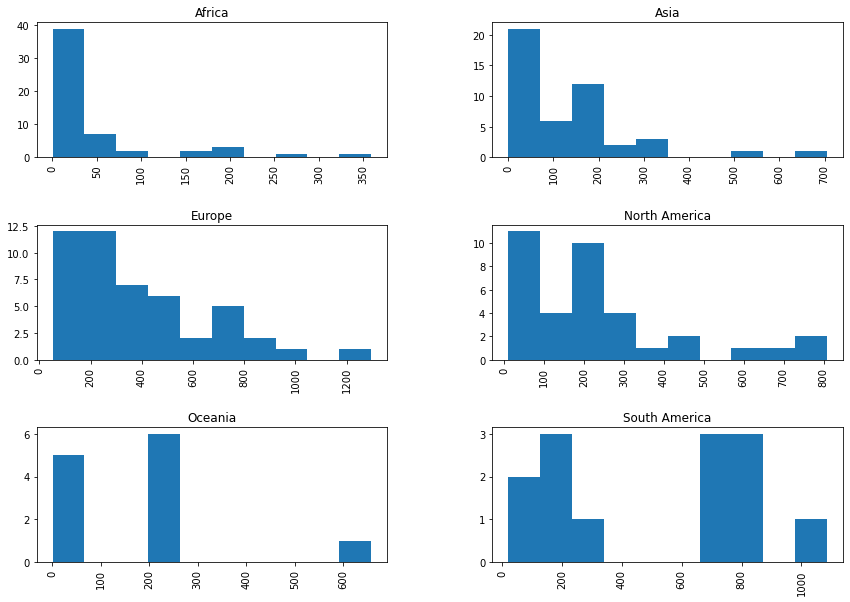

In [26]:
owid['total_deaths_per_million'].hist(by=owid['continent'],figsize=(14,10))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11d2c73d0>,
      dtype=object)

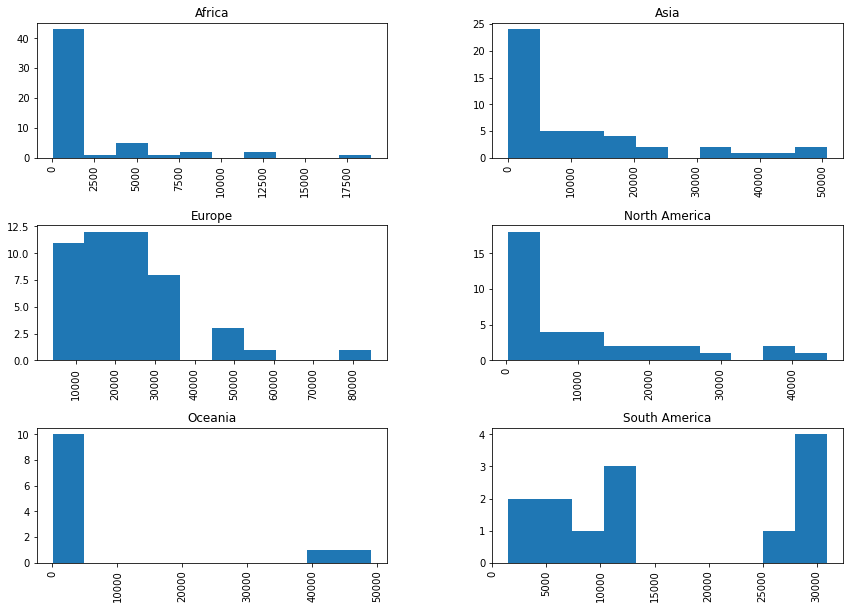

In [27]:
owid['total_cases_per_million'].hist(by=owid['continent'],figsize = (14,10))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11d9374f0>,
      dtype=object)

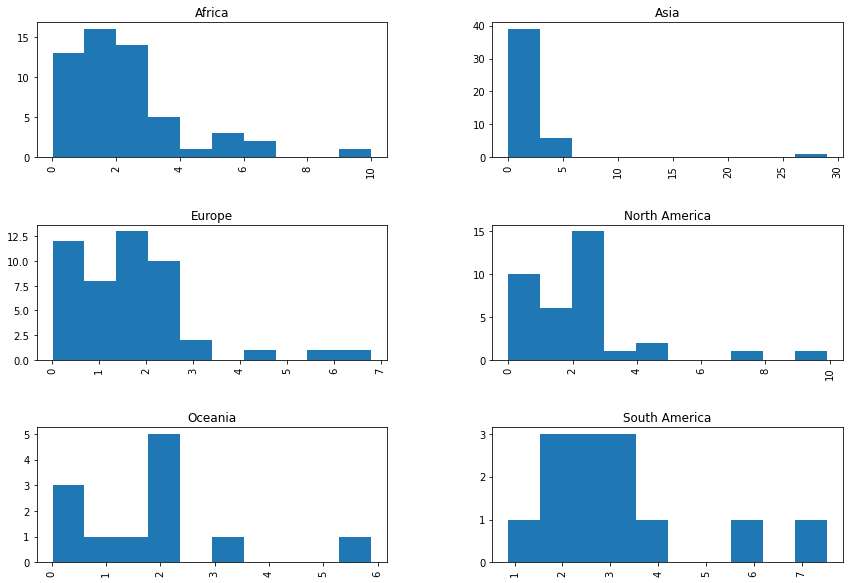

In [28]:
owid['deathrate'].hist(by=owid['continent'],figsize=(14,10))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11c8ef100>,
      dtype=object)

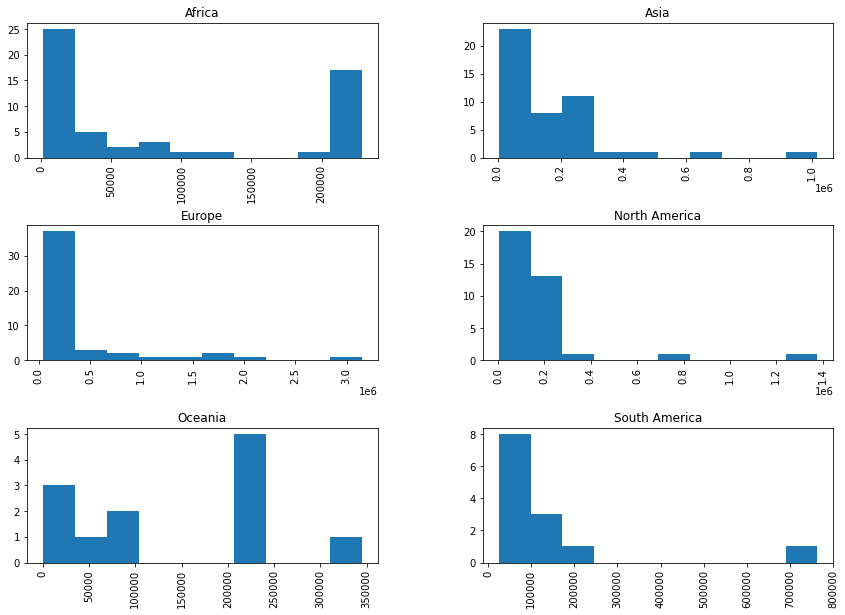

In [30]:
owid['testspermillion'].hist(by=owid['continent'],figsize=(14,10))

In [31]:
#Creating dummy variables and scaling to get ready for modeling

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

scaled_df = owid.drop(['country','first_case','continent'],axis=1)
scaler = StandardScaler()
scaled_array = scaler.fit_transform(scaled_df)
scaled_df = pd.DataFrame(scaled_array,columns=scaled_df.columns)

dfo=owid['continent']
owid_dummies = pd.concat([scaled_df, pd.get_dummies(dfo)], axis=1)
owid_dummies.head()

,level_0,index,total_cases_per_million,total_deaths_per_million,deathrate,testspermillion,population,population_density,median_age,aged_70_older,...,workplace_avg_change,workplace_peak_change,residential_avg_change,residential_peak_change,Africa,Asia,Europe,North America,Oceania,South America
0,-1.721832,-1.721832,2.550446,0.919925,-0.480099,0.531374,-0.281584,0.572753,1.180106,0.476913,...,-9.498217e-01,-0.958625,0.738381,-1.994550e-01,0,0,0,1,0,0
1,-1.701334,-1.701334,-0.772315,-0.602840,0.611840,-0.466338,-0.034906,-0.243518,-1.331091,-0.993772,...,7.821006e-01,1.161239,-0.701743,-1.448819e+00,0,1,0,0,0,0
2,-1.680836,-1.680836,-0.826698,-0.741333,0.200541,-0.467838,-0.073425,-0.290508,-1.531097,-0.987759,...,1.017846e+00,0.603380,0.898457,1.412807e-01,1,0,0,0,0,0
3,-1.660338,-1.660338,0.079462,0.274133,0.128114,-0.361028,-0.263976,-0.165876,0.824538,0.763354,...,-8.446940e-16,0.000000,0.000000,8.070243e-16,0,0,1,0,0,0
4,-1.639840,-1.639840,0.399353,-0.552716,-0.799605,10.583560,-0.219417,-0.154223,0.380079,-1.188821,...,-3.055654e-02,0.380237,0.859526,4.820164e-01,0,1,0,0,0,0


In [55]:
owid_dummies.columns

Index(['level_0', 'index', 'total_cases_per_million',
       'total_deaths_per_million', 'deathrate', 'testspermillion',
       'population', 'population_density', 'median_age', 'aged_70_older',
       'gdp_per_capita', 'extreme_poverty', 'stringency_index',
       'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers',
       'male_smokers', 'hospital_beds_per_thousand', 'life_expectancy',
       'human_development_index', 'days_since_firstcase',
       'retail_rec_avg_change', 'retail_rec_peak_change',
       'grocery_pharmacy_avg_change', 'grocery_pharmacy_peak_change',
       'parks_avg_change', 'parks_peak_change', 'transit_station_avg_change',
       'transit_station_peak_change', 'workplace_avg_change',
       'workplace_peak_change', 'residential_avg_change',
       'residential_peak_change', 'Africa', 'Asia', 'Europe', 'North America',
       'Oceania', 'South America'],
      dtype='object')

In [57]:
#Defining X as predictive variables and Y (cases per million), 
#Y2(deaths per million), and Y3(deathrate) as the target variables

X = owid_dummies.drop(['total_cases_per_million', 'total_deaths_per_million', 'deathrate'],axis=1) 
Y = owid_dummies['total_cases_per_million'] 
Y2 = owid_dummies['total_deaths_per_million']
Y3 = owid_dummies['deathrate']
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

Slope: [-0.0448652  -0.0448652   0.07000446 -0.0567914  -0.08529262  0.27891217
 -0.31952989  0.17888789 -0.01566406  0.01543366  0.06097317 -0.04335715
  0.46910504 -0.08020791  0.02205855  0.15351901  0.02758899 -0.10236845
 -0.32851925  0.24526312  0.07477677 -0.06912966 -0.13099231 -0.2198458
  0.22786731  0.04791489 -0.06392679 -0.06574369  0.22759456 -0.10712892
  0.08108425  0.26284737  0.39385273 -0.00461639 -0.83287874  0.09971079]
Intercept: -0.1574795662017842
Root mean squared error:  0.6507073995750399
R2 score:  0.39979427539654255


Text(0, 0.5, 'Y-Test')

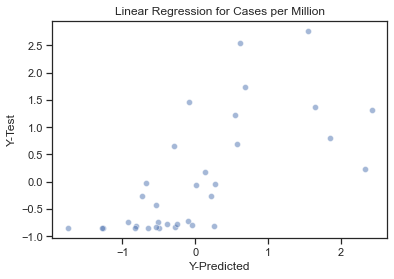

In [65]:
#Linear Regression for Y

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20,random_state=43)

x = X_train
y = y_train

regression_model = LinearRegression()
regression_model.fit(x, y)
y_predicted = regression_model.predict(X_test)

rmse = mean_squared_error(y_test, y_predicted)
r2 = r2_score(y_test, y_predicted)

# printing values
print('Slope:' ,regression_model.coef_)
print('Intercept:', regression_model.intercept_)
print('Root mean squared error: ', rmse)
print('R2 score: ', r2)

# predicted values
sns.scatterplot(y_predicted, y_test,alpha = 0.5)
plt.title('Linear Regression for Cases per Million')
plt.xlabel('Y-Predicted')
plt.ylabel('Y-Test')

Slope: [-0.05141782 -0.05141782 -0.03245218 -0.03510388 -0.11210996  0.21891083
 -0.17053663 -0.0842172  -0.05390516  0.01764673  0.07783695 -0.04381817
  0.32556313 -0.09933087 -0.0573261   0.01704797  0.06682772  0.05839604
 -0.32104298  0.20018228  0.09525211 -0.12700708 -0.05911699 -0.1563096
  0.10830194  0.17410803 -0.09278016 -0.09211743  0.13328391  0.03095605
 -0.30338686 -0.2202614   0.38446324  0.00141707 -0.50249851  0.64026645]
Intercept: 0.05189062874573407
Root mean squared error:  0.36297425033298847
R2 score:  0.5878280208535076


Text(0, 0.5, 'Y-Test')

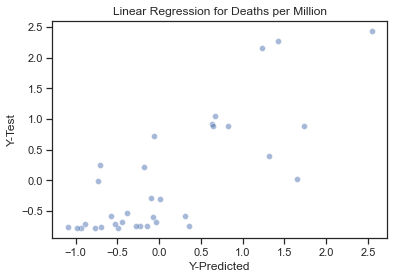

In [66]:
#Linear Regression for Y2

X_train, X_test, y_train, y_test = train_test_split(X, Y2, test_size=0.20,random_state=43)

x = X_train
y = y_train

regression_model = LinearRegression()
regression_model.fit(x, y)
y_predicted = regression_model.predict(X_test)

rmse = mean_squared_error(y_test, y_predicted)
r2 = r2_score(y_test, y_predicted)

# printing values
print('Slope:' ,regression_model.coef_)
print('Intercept:', regression_model.intercept_)
print('Root mean squared error: ', rmse)
print('R2 score: ', r2)

# predicted values
sns.scatterplot(y_predicted, y_test,alpha = 0.5)
plt.title('Linear Regression for Deaths per Million')
plt.xlabel('Y-Predicted')
plt.ylabel('Y-Test')

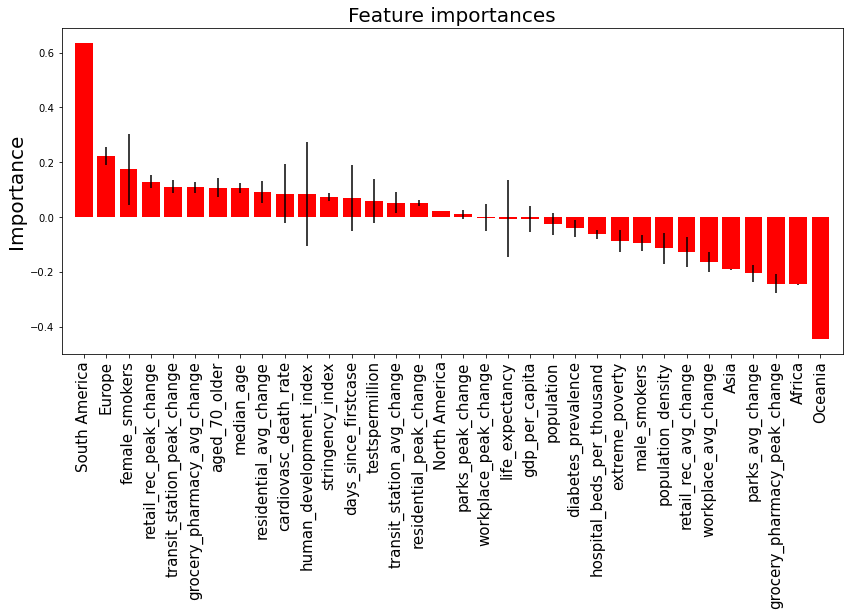

In [618]:
#Importance for Linear Regression of Y2 (Later selected as the best model for predicting Y2)

from matplotlib import pyplot
importance = regression_model.coef_
indices = np.argsort(importance)[::-1]
feature_names = [X.columns[i] for i in indices]
plt.figure(figsize=(14,6))
plt.title("Feature importances",fontsize=20)
plt.bar(range(X.shape[1]), importance[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), feature_names,fontsize=15)
plt.tick_params(axis='x', labelrotation = 90)
plt.xlim([-1, X.shape[1]])
plt.ylabel("Importance", fontsize = 20)
plt.show()

Slope: [ 0.02219667  0.02219667 -0.05588494  0.03945167 -0.14008119 -0.11604551
  0.70612776  0.16184285 -0.17135841 -0.07743555  0.06148007  0.03605812
 -0.16859361 -0.03236989 -0.09261222  0.39979736 -0.96709631  0.0926618
  0.51109989  0.07134464  0.35469939 -0.34477579 -0.36733021 -0.13861558
 -0.03829406  0.22698545 -0.3490715   0.44576108  0.15678024  0.11669768
 -0.1375989   0.03841982  0.05224056  0.08331434 -0.69675759  0.66038177]
Intercept: 0.009205713135455776
Root mean squared error:  0.9653908638467215
R2 score:  -0.9498981905666628


Text(0, 0.5, 'Y-Test')

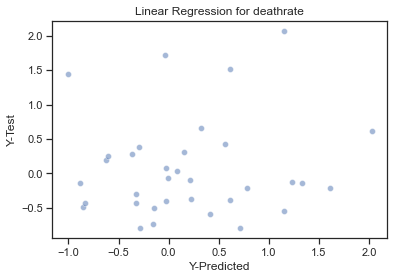

In [67]:
#LinearRegressionY3
X_train, X_test, y_train, y_test = train_test_split(X, Y3, test_size=0.20,random_state=43)
x = X_train
y = y_train

regression_model = LinearRegression()
regression_model.fit(x, y)
y_predicted = regression_model.predict(X_test)

rmse = mean_squared_error(y_test, y_predicted)
r2 = r2_score(y_test, y_predicted)

# printing values
print('Slope:' ,regression_model.coef_)
print('Intercept:', regression_model.intercept_)
print('Root mean squared error: ', rmse)
print('R2 score: ', r2)

# predicted values
sns.scatterplot(y_predicted, y_test,alpha = 0.5)
plt.title('Linear Regression for deathrate')
plt.xlabel('Y-Predicted')
plt.ylabel('Y-Test')

In [141]:
#RandomForestY

from sklearn.ensemble import RandomForestRegressor
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20,random_state=43)
rfc = RandomForestRegressor()
rfc = rfc.fit(X_train,y_train)

In [122]:
#GridSearch for optimizing hyperparameters for Y Random Forest

param_grid = { 
    'n_estimators': [5,6,7,8,9,10,15,20,25],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [5,10,15,20,30,40,50,60,70,80,90,100,120],
}
CV_rfc1 = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc1.fit(X_train, y_train)
CV_rfc1.best_params_

{'max_depth': 40, 'max_features': 'sqrt', 'n_estimators': 15}

0.8756821890540548


Text(0, 0.5, 'Y-Test')

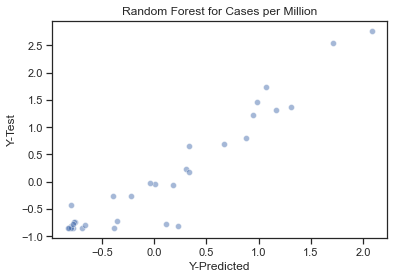

In [142]:
from sklearn import metrics
rfc = RandomForestRegressor(random_state=43, max_features='sqrt', n_estimators= 15, max_depth=40)
rfc.fit(X_train,y_train)
y_pred_rfr = rfc1.predict(X_test)
r_square = metrics.r2_score(y_test,y_pred_rfr)
print(r_square)
sns.scatterplot(y_pred_rfr, y_test,alpha = 0.5)
plt.title('Random Forest for Cases per Million')
plt.xlabel('Y-Predicted')
plt.ylabel('Y-Test')

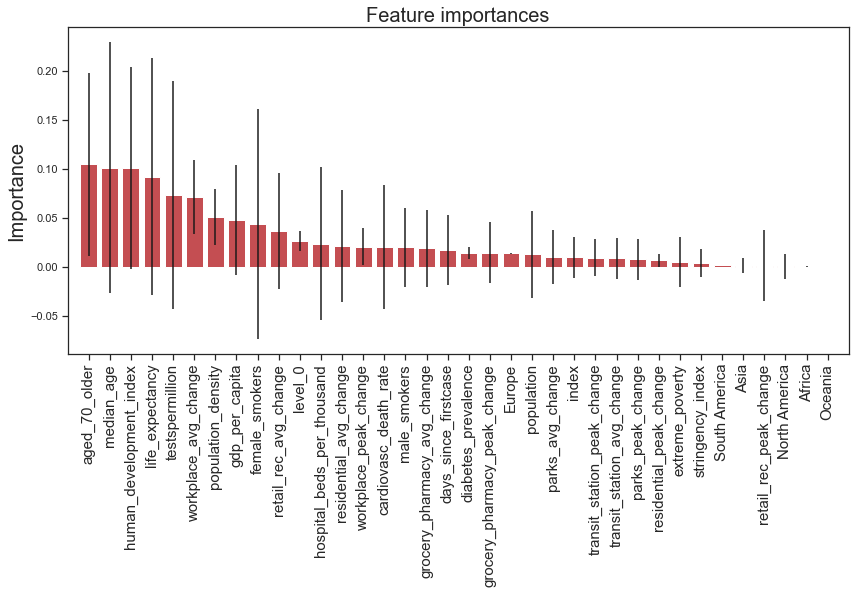

In [127]:
#Feature Importance order for Random Forest Model for Y (Later selected as the best model for Y)
importances = rfc1.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
feature_names = [X.columns[i] for i in indices]
plt.figure(figsize=(14,6))
plt.title("Feature importances",fontsize=20)
plt.bar(range(X.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), feature_names,fontsize=15)
plt.tick_params(axis='x', labelrotation = 90)
plt.xlim([-1, X.shape[1]])
plt.ylabel("Importance", fontsize = 20)
plt.show()

In [143]:
#RandomForestY2

from sklearn.ensemble import RandomForestRegressor
X_train, X_test, y_train, y_test = train_test_split(X, Y2, test_size=0.20,random_state=43)
rfc2 = RandomForestRegressor()
rfc2 = rfc.fit(X_train,y_train)

In [130]:
#GridSearch for optimizing hyperparameters for Y2 Random Forest

param_grid = { 
    'n_estimators': [5,6,7,8,9,10,15,20,25],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [5,10,15,20,30,40,50,60,70,80,90,100,120],
}
CV_rfc = GridSearchCV(estimator=rfc2, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)
CV_rfc.best_params_

{'max_depth': 5, 'max_features': 'auto', 'n_estimators': 9}

0.4930360649650194


Text(0, 0.5, 'Y-Test')

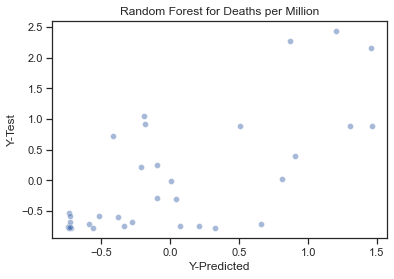

In [145]:
rfc2 = RandomForestRegressor(random_state=43, max_features='auto', n_estimators= 9, max_depth=8)
rfc2.fit(X_train,y_train)
y_pred_rfr = rfc2.predict(X_test)
r_square = metrics.r2_score(y_test,y_pred_rfr)
print(r_square)
sns.scatterplot(y_pred_rfr, y_test,alpha = 0.5)
plt.title('Random Forest for Deaths per Million')
plt.xlabel('Y-Predicted')
plt.ylabel('Y-Test')

In [146]:
#RandomForestY3

from sklearn.ensemble import RandomForestRegressor
X_train, X_test, y_train, y_test = train_test_split(X, Y3, test_size=0.20,random_state = 46)
rfc3 = RandomForestRegressor(random_state = 46)
rfc3 = rfc.fit(X_train,y_train)

In [147]:
#GridSearch for optimizing hyperparameters for Y3 Random Forest
param_grid = { 
    'n_estimators': [5,6,7,8,9,10,15,20,25],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [5,10,15,20,30,40,50,60,70,80,90,100,120],
}
CV_rfc = GridSearchCV(estimator=rfc3, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)
CV_rfc.best_params_

{'max_depth': 15, 'max_features': 'log2', 'n_estimators': 9}

-1.0283989105252624


Text(0, 0.5, 'Y-Test')

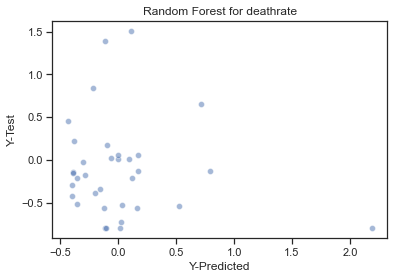

In [148]:
rfc3 = RandomForestRegressor(random_state=46, max_features='log2', n_estimators= 9, max_depth=15)
rfc3.fit(X_train,y_train)
y_pred_rfr = rfc3.predict(X_test)
r_square = metrics.r2_score(y_test,y_pred_rfr)
print(r_square)
sns.scatterplot(y_pred_rfr, y_test,alpha = 0.5)
plt.title('Random Forest for deathrate')
plt.xlabel('Y-Predicted')
plt.ylabel('Y-Test')

In [168]:
#GradientBoosterY

from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import datasets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,random_state=46)

In [152]:
#GridSearch for optimizing hyperparameters for Y Gradient Booster

GBR = GradientBoostingRegressor(random_state=46)
GBR.fit(X_train,y_train)
param = { 
    'n_estimators': [5,6,7,8,9,10,15,20,25],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [5,10,15,20,30,40,50,60,70,80,90,100,120],
}

grid_GBR = GridSearchCV(estimator=GBR, param_grid = param, cv = 5)
grid_GBR.fit(X_train, y_train)

grid_GBR.best_params_


{'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 25}

0.37832997091991194


Text(0, 0.5, 'Y-Test')

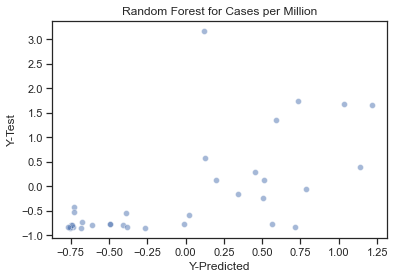

In [174]:
gbr1 = GradientBoostingRegressor(random_state=46,max_depth = 10, max_features = 'sqrt',n_estimators = 26)
gbr1.fit(X_train, y_train)
y_pred_gb = gbr1.predict(X_test)
print(gbr1.score(X_test, y_test))
sns.scatterplot(y_pred_gb, y_test, alpha = 0.5)
plt.title('Random Forest for Cases per Million')
plt.xlabel('Y-Predicted')
plt.ylabel('Y-Test')

In [175]:
#GradientBoostingY2
X_train, X_test, y_train, y_test = train_test_split(X, Y2, test_size=0.2,random_state=46)

In [159]:
#GridSearch for optimizing hyperparameters for Y2 Gradient Booster
GBR = GradientBoostingRegressor(random_state=46)
GBR.fit(X_train,y_train)
param = { 
    'n_estimators': [5,6,7,8,9,10,15,20,25],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [5,10,15,20,30,40,50,60,70,80,90,100,120],
}

grid_GBR = GridSearchCV(estimator=GBR, param_grid = param, cv = 5)
grid_GBR.fit(X_train, y_train)

grid_GBR.best_params_

{'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 20}

0.5316134620774784


Text(0, 0.5, 'Y-Test')

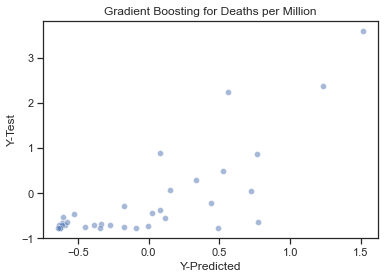

In [176]:
gbr2 = GradientBoostingRegressor(random_state=46,max_depth = 20, max_features = 'sqrt',n_estimators = 19)
gbr2.fit(X_train, y_train)
y_pred_gb = gbr2.predict(X_test)
print(gbr2.score(X_test, y_test))
sns.scatterplot(y_pred_gb, y_test, alpha = 0.5)
plt.title('Gradient Boosting for Deaths per Million')
plt.xlabel('Y-Predicted')
plt.ylabel('Y-Test')

In [178]:
#GradientBoostingY3
X_train, X_test, y_train, y_test = train_test_split(X, Y3, test_size=0.2,random_state=46)

In [179]:
#GridSearch for optimizing hyperparameters for Y3 Gradient Booster
GBR = GradientBoostingRegressor(random_state=46)
GBR.fit(X_train,y_train)
param = { 
    'n_estimators': [5,6,7,8,9,10,15,20,25],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [5,10,15,20,30,40,50,60,70,80,90,100,120],
}

grid_GBR = GridSearchCV(estimator=GBR, param_grid = param, cv = 5)
grid_GBR.fit(X_train, y_train)

grid_GBR.best_params_

{'max_depth': 10, 'max_features': 'log2', 'n_estimators': 5}

0.029552637938698112


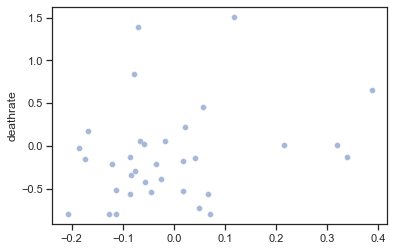

In [180]:
gbr3 = GradientBoostingRegressor(random_state = 46, max_depth = 10, max_features = 'log2',n_estimators = 5)
gbr3.fit(X_train, y_train)
y_pred_gb = gbr3.predict(X_test)
print(gbr3.score(X_test, y_test))
sns.scatterplot(y_pred_gb, y_test, alpha = 0.5)

We find that the best model to predict total cases per million (Y) is the Random Forest model with an r-squared of 0.8756821890540548, higher than that of the other two models (Linear Regression and Gradient Boosting). However, for the total deaths per million variable (Y2), the Linear Regression Model is the best to predict, with the r-squared of 0.5878280208535076 being the highest for the linear regression. For Deathrate, the highest r-squared achieved was from the Random Forest with an r-squared of 0.029552637938698112. Therefore, it seems clear we are unable predict the deathrate using this data and would need more information. Refer to the Linear Regression of Y2 and the Random Forest Model of Y for the feature importances of the models.